In [1]:
%load_ext autoreload
%autoreload 2

from dataloader import SwatDataset
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

import pickle
import os
import torch
import pandas as pd
from tqdm import tqdm
from torch.utils.data import TensorDataset

# from pprint import pprint
import wandb

import matplotlib.pyplot as plt

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [2]:
# col_list = [1, 2, 3, 4, 6, 12, 14, 16, 18, 21, 22, 24, 27, 28, 29, 33, 35, 42, 49]
# train_dataset = SwatDataset("./data/train_norm.npy", feature_idx=col_list, start_idx=10_000, end_idx=-1,
#                              window_size=100, sliding=7)
# val_dataset = SwatDataset("./data/validation_norm.npy", feature_idx=col_list, start_idx=0, end_idx=-1,
#                              window_size=100, sliding=100, labels_path="./data/labels_validation.npy")
# test_dataset = SwatDataset("./data/test_norm.npy", feature_idx=col_list, start_idx=0, end_idx=-1,
#                              window_size=100, sliding=100, labels_path='./data/labels_test.npy')

# len(train_dataset), len(val_dataset), len(test_dataset)

col_list = [1, 2, 3, 4, 6, 12, 14, 16, 18, 21, 22, 24, 27, 28, 29, 33, 35, 42, 49]
train_dataset_minmax = SwatDataset("./data/train.npy", feature_idx=col_list, start_idx=10_000, end_idx=-1,
                             window_size=100, sliding=7)
val_dataset_minmax = SwatDataset("./data/validation.npy", feature_idx=col_list, start_idx=0, end_idx=-1,
                             window_size=100, sliding=100, labels_path="./data/labels_validation.npy")
test_dataset_minmax = SwatDataset("./data/test.npy", feature_idx=col_list, start_idx=0, end_idx=-1,
                             window_size=100, sliding=100, labels_path='./data/labels_test.npy')

len(train_dataset_minmax), len(val_dataset_minmax), len(test_dataset_minmax)

(69270, 402, 4092)

In [3]:
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

train_loader = DataLoader(train_dataset_minmax, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset_minmax, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset_minmax, batch_size=128, shuffle=False)

# val_train_loader = DataLoader(val, batch_size=64, shuffle=False, num_workers=4)
len(train_loader), len(val_loader), len(test_loader)

(542, 4, 32)

In [10]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: a-gruzitski. Use `wandb login --relogin` to force relogin


True

### VAE

In [11]:
LEARNING_RATE = 1e-5
WEIGHT_DECAY= 0
WINDOW_SIZE = 100
NUM_EPOCHS = 15

run = wandb.init(
    project="anomaly-detection_VAE",
    config={
        "model": "VAE with activation",
        "learning_rate": LEARNING_RATE,
        "epochs": NUM_EPOCHS,
        # "label": "aaa",
        "window_size": WINDOW_SIZE,
        "weight_decay": WEIGHT_DECAY,
        "optimizer": "SGD",
        # "optimizer": "Adam",
        "scheduler": None,
        # "scheduler" : "transf_warmup",
        "finetune": True
    },
);


In [46]:
import models
from torch.optim import Adam, SGD
from training import train, train_vae

from transformers import get_linear_schedule_with_warmup

criterion = torch.nn.MSELoss()  # validation criterion
 
model = models.VAE_act(feats=len(col_list), 
                        window_size=100).to(device)

# for p in model.parameters():
#     if p.dim() > 1:
#         torch.nn.init.xavier_uniform_(p)

optimizer = Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

   
# optimizer = SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
# scheduler = None

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-4, steps_per_epoch=2, epochs=NUM_EPOCHS)

scheduler = get_linear_schedule_with_warmup(optimizer, 2, NUM_EPOCHS)
# lambda1 = lambda epoch: 0.7 ** epoch
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

c:\Users\Andrew23\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [64]:
import models
from torch.optim import Adam, SGD
from training import train, train_vae

model = models.VAE_act(feats=len(col_list), 
                        window_size=100).to(device)
model.load_state_dict(torch.load("checkpoints\VAE_act39e.pt"))
criterion = torch.nn.MSELoss()

data is ready!


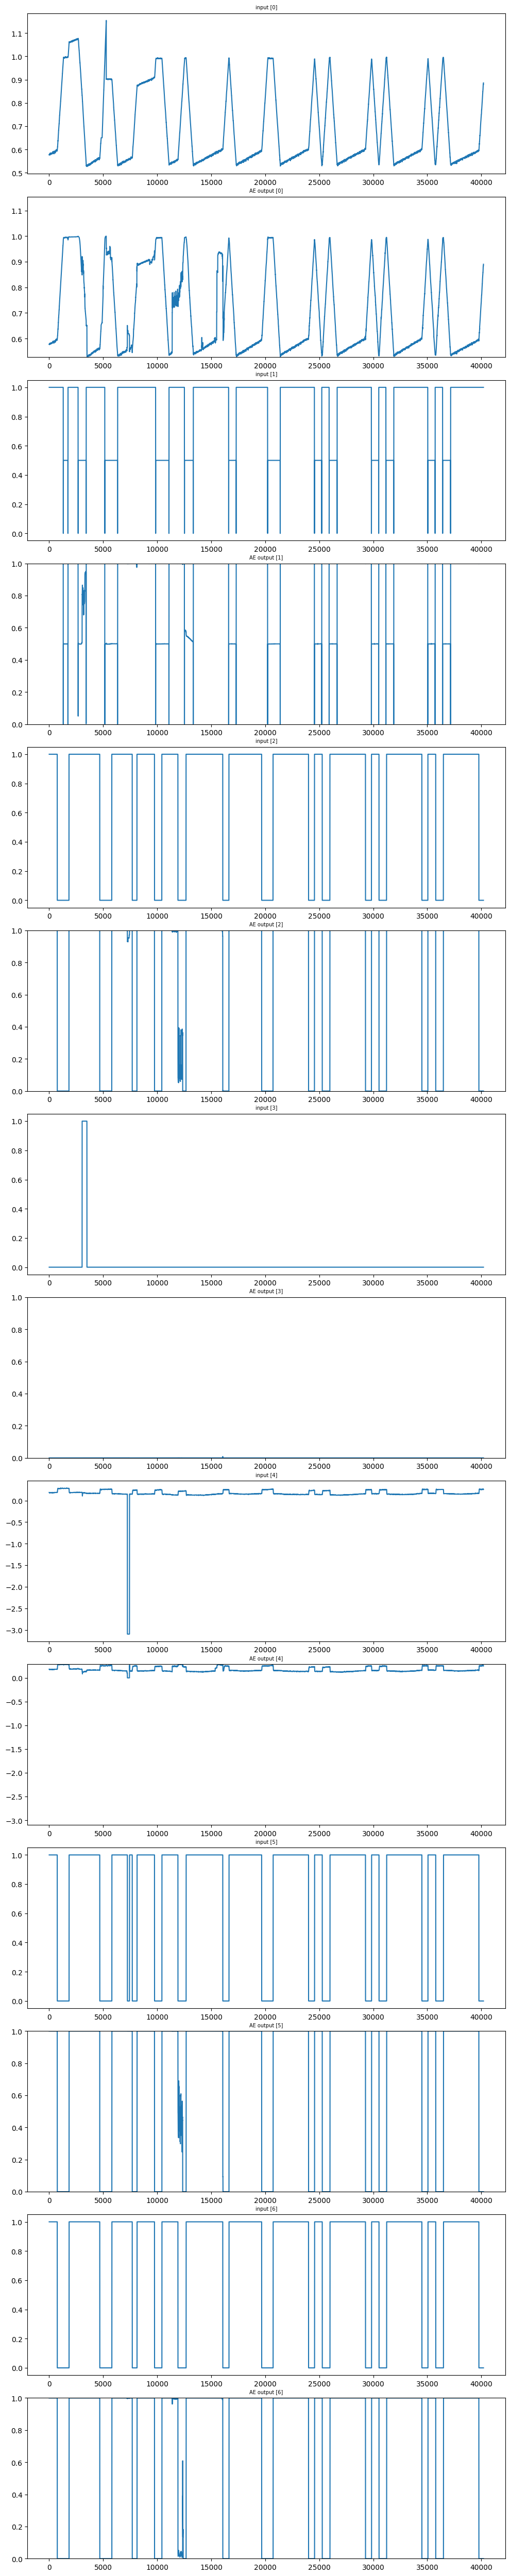

In [65]:
from training import train_vae_epoch
from training import train, train_vae

# train_vae_epoch(model, optimizer, train_loader,
#                     "training", device=device)

optimizer = SGD(model.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = None

train_losses, test_losses = train_vae(
    model, optimizer, scheduler, criterion, train_loader, val_loader, 10,
    device, start_epoch=41,
    # save_checkpoints=True,
    val_labels_path="./data/labels_validation.npy",
)

In [66]:
torch.save(model.state_dict(), 'checkpoints/VAE_act50e_1.pt')

### VAE evaluation

data is ready!


c:\university\course_work\training.py:373: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs[2*i+1].plot(output[:, i])


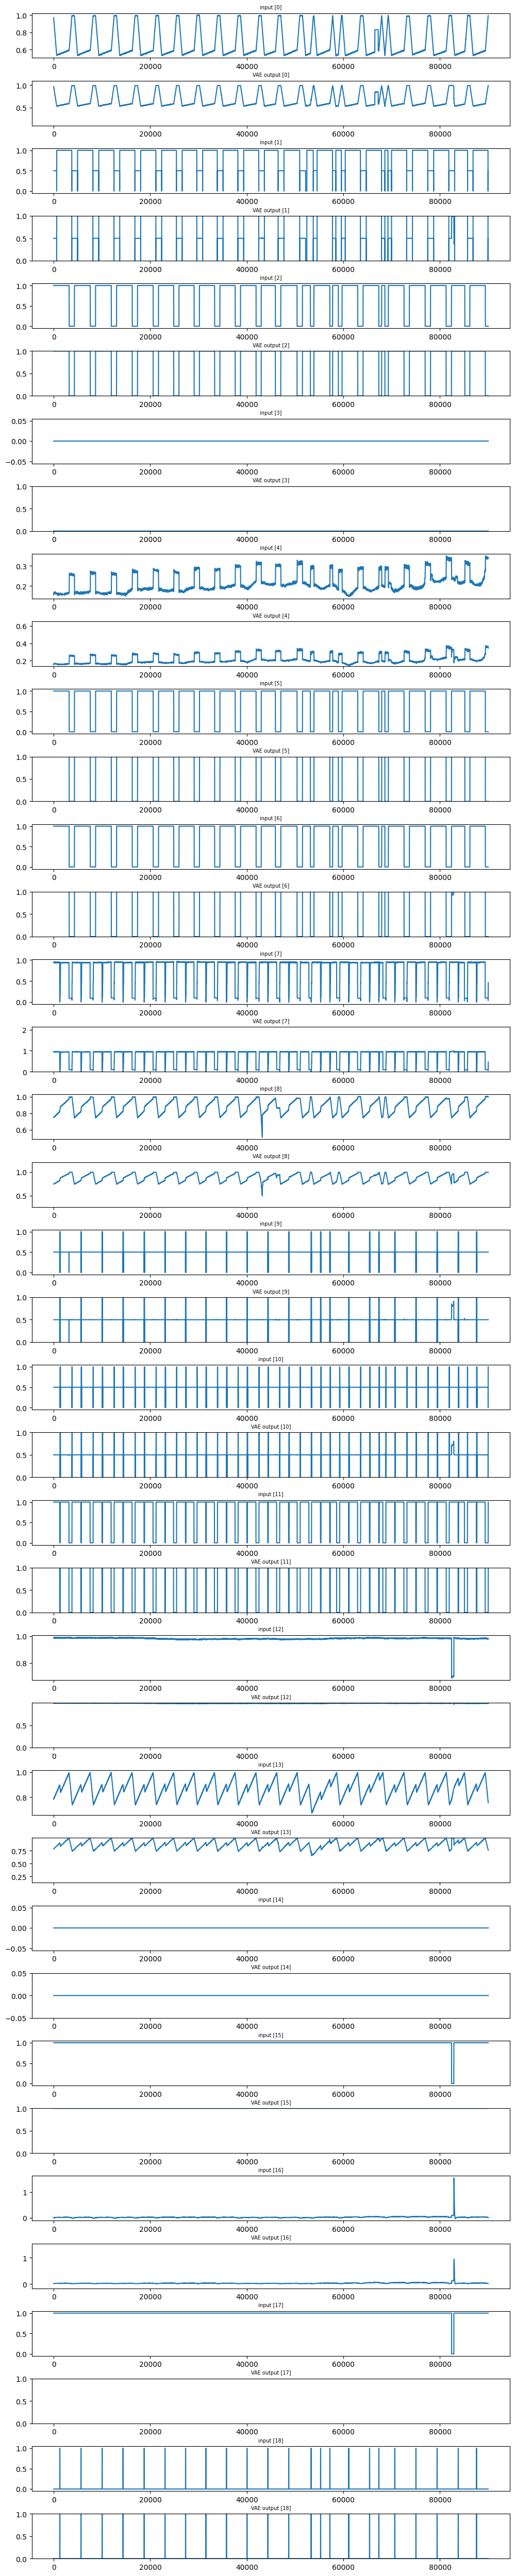

In [52]:
from training import plot_output

plot_output(model, test_loader, device=device, param_dim=19, max_plots=19, model_name="VAE")

In [67]:
import metrics_eval
from training import validation_vae_epoch

test_labels = np.load("./data/labels_test.npy")

_, full_test_loss, _ = validation_vae_epoch(model, criterion, test_loader,
                      "getting full loss", 0, device=device)
loss_w = full_test_loss.mean(axis=2)
loss_w = loss_w.reshape(-1)

# metrics_eval.evaluate(loss_w, test_labels, validation_thresh=None)

test_vae_res = metrics_eval.evaluate(loss_w, test_labels, validation_thresh=0.032681314945220946)
test_vae_res

getting full loss:   0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 50/50 [11:32<00:00, 13.86s/it]


{'f1': 0.8806636942125472,
 'ROC/AUC': 0.9103157946860158,
 'f1_max': 0.8951061217330293,
 'preds': array([False, False, False, ..., False, False, False]),
 'k': 0,
 'thresh_max': 0.032681314945220946,
 'roc_max': 0.9103157946860158}

In [21]:
loss_w.shape, np.random.normal(size=test_labels.shape).shape

((409200,), (409427,))

In [22]:
# example that metrics is not broken
metrics_eval.evaluate(np.random.normal(size=test_labels.shape) + 1, test_labels, validation_thresh=0.032681314945220946)

100%|██████████| 50/50 [12:12<00:00, 14.64s/it]


{'f1': 0.24481398249799852,
 'ROC/AUC': 0.4724460398132642,
 'f1_max': 0.2508101134158782,
 'preds': array([False,  True,  True, ..., False,  True,  True]),
 'k': 0,
 'thresh_max': 0.032681314945220946,
 'roc_max': 0.4724460398132642}

In [54]:
test_vae_res2 = metrics_eval.evaluate(loss_w, test_labels, validation_thresh=0.07)
test_vae_res2

100%|██████████| 50/50 [11:32<00:00, 13.84s/it]


{'f1': 0.8525439225246061,
 'ROC/AUC': 0.9103152057501136,
 'f1_max': 0.871785678270905,
 'preds': array([False, False, False, ..., False, False, False]),
 'k': 0,
 'thresh_max': 0.07,
 'roc_max': 0.9103152057501136}

In [55]:
test_vae_res3 = metrics_eval.evaluate(loss_w, test_labels, validation_thresh=0.035)
test_vae_res3

100%|██████████| 50/50 [11:28<00:00, 13.77s/it]


{'f1': 0.8805713030288086,
 'ROC/AUC': 0.9103152057501136,
 'f1_max': 0.8917703212467144,
 'preds': array([False, False, False, ..., False, False, False]),
 'k': 0,
 'thresh_max': 0.035,
 'roc_max': 0.9103152057501136}

### TSNE

In [24]:
import models

model = models.VAE_act(feats=len(col_list), 
                        window_size=100).to(device)
model.load_state_dict(torch.load("checkpoints\VAE_act39e.pt"))

c:\Users\Andrew23\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


<All keys matched successfully>

In [47]:
from collections import defaultdict

def get_representations(dataloader, encoder, device):
    representations = {0: [], 1: []}
    for feat, label in tqdm(dataloader, leave=False):
        feat= feat.to(device)
        embedding = encoder(feat)
        # print(int(label.sum() > 50), embedding.shape)
        
        representations[int(label.sum() > 50)].append(embedding.cpu().reshape(-1))
    return representations

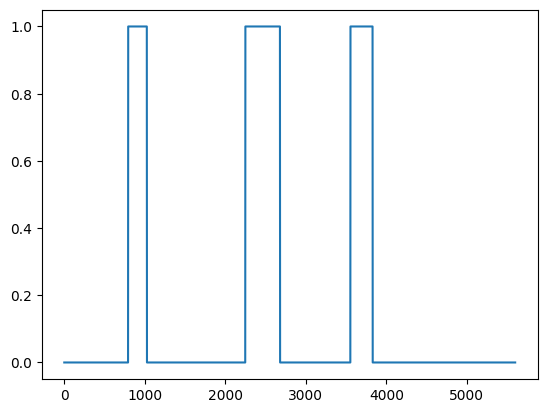

In [48]:
test_dataset_minmax = SwatDataset("./data/test.npy", feature_idx=col_list, start_idx=0, end_idx=-1,
                             window_size=100, sliding=100, labels_path='./data/labels_test.npy')
test_loader_by_elements = DataLoader(test_dataset_minmax, batch_size=1, shuffle=False)

plt.plot(test_dataset_minmax.labels[49400:55000])

In [68]:
representations = get_representations(test_loader_by_elements, model.get_latent_embedding, device=device)

In [69]:
len(representations[0]), len(representations[1])

(3595, 497)

In [70]:
[1, 2, 3] + [1]

[1, 2, 3, 1]

In [72]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=0)

vectors = torch.stack(representations[0] + representations[1], dim=0).cpu().detach().numpy()
embed = tsne.fit_transform(vectors)

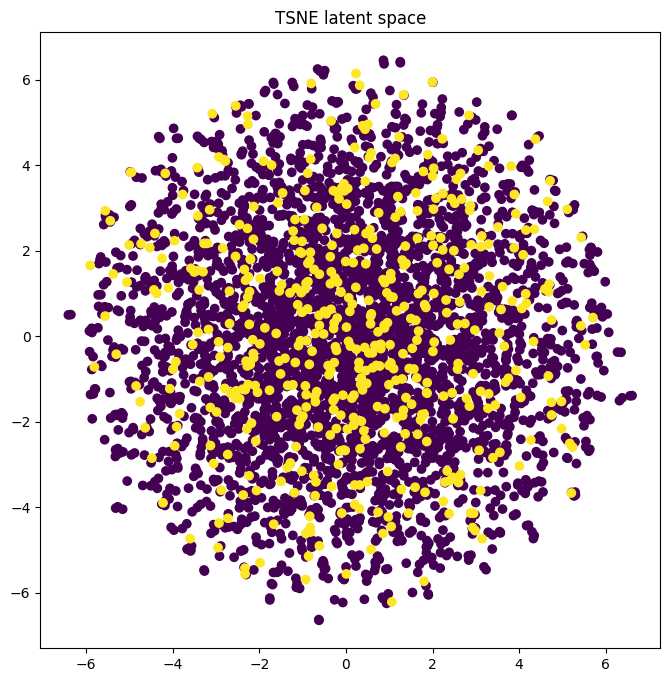

In [73]:
colors = [0] * len(representations[0]) + [1] * len(representations[1])
plt.figure(figsize=(8, 8))
plt.scatter(embed[:, 0], embed[:, 1], c=colors)
plt.title('TSNE latent space')
plt.show()